# Data Exploration of Chicago Crimes Data

I performed a brief exploratory analysis of the cleaned dataset. I only left a few interesting visualizations here and moved most of them to a Power BI dashboard for further exploration.  
  
One of the most interesting trends I want to point out is how the raw counts of crimes and homicides can be deceiving. Looking specifically at the plots showing the Community Areas with the Least and Most Crimes with both the raw counts and crimes per capita in the [All Crimes and Homicides by Community Area](#comm_areas) section, we can see that Fuller Park is among the community areas with the least amount of crime, but when looking at the crimes per capita (the raw counts divided by the 2010 Census population sizes), Fuller Park has more crime per capita than all the  community areas in Chicago.

## Table of Contents
* [Description of Columns](#col_description)
* [Reading in Cleaned Dataset](#read_data)
* [Retrieving Region and Community Area Populations for Normalizing Counts](#populations)
* [Plotting Function](#plot_func)
* [All Crimes and Homicides by Region](#region)
* [All Crimes and Homicides by Community Area](#comm_areas)
* [Crimes and Homicides by Date Columns](#dates)  
    - [Date](#date)  
    - [Time of Day](#time)  
    - [Season](#season)  

<a id="col_description">

## Description of Columns
The original column descriptions from the City of Chicago 
[website](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2).

| Column Name  | Column Description |  
| :-:    | :-- |  
| Date                 | Date when the incident occurred (sometimes an estimate) |
| Primary Type         | The primary description of the IUCR code |
| Arrest               | Indicates whether an arrest was made |
| Domestic             | Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence act |
| Year                 | The year the incident occurred |
| Location             | The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block |
| Location Description | Description of the location where the incident occurred |
| Community Area       | Indicates the community area where the incident occurred (Chicago has 77 community areas) |
| Region               | Indicates the region of Chicago where the incident occurred |
| 2010 Population      | Indicates the community area where the incident occurred (Chicago has 77 community areas) |
| Month                | Indicates the month the incident occurred |
| Day of Week          | Indicates the day of the week the incident occurred |
| Time of Day          | Indicates the time of day where the incident occurred (Morning, Afternoon, Evening, Night) |
| Sesaon               | Indicates the season when the incident occurred (Spring, Summer, Fall, Winter)  |

<a id="read_data">

## Reading in the Cleaned Dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [43]:
crimes = pd.read_csv('Data/crimes_cleaned.csv', parse_dates=['Date'])

In [44]:
print("Number of Crimes from {} to {}: {:,d}".format(crimes.Date.min(),crimes.Date.max(),crimes.shape[0]))
print("Approximate Average Crimes per Day: {:,.0f}".format(crimes.shape[0]/(122*30))) #122 months x 30 days per month

Number of Crimes from 2010-01-01 00:00:00 to 2020-02-29 23:59:00: 2,985,145
Approximate Average Crimes per Day: 816


In [45]:
crimes.head()

,Date,Primary Type,Arrest,Domestic,Year,Location,Location Description,Community Area,Region,2010 Population,Month,Day of Week,Time of Day,Season
0,2019-04-10 16:37:00,Sex Offense,False,False,2019,"(41.708589, -87.612583094)",School,Roseland,Far Southeast Side,44619.0,4,Wednesday,Afternoon,Spring
1,2019-04-19 13:57:00,Offense Involving Children,False,True,2019,"(41.884865037, -87.755230327)",Residence,Austin,West Side,98514.0,4,Friday,Afternoon,Spring
2,2019-04-12 16:08:00,Offense Involving Children,False,True,2019,"(41.940297617, -87.732066473)",Residence,Irving Park,Northwest Side,53359.0,4,Friday,Afternoon,Spring
3,2019-04-25 17:20:00,Battery,False,True,2019,"(41.697609261, -87.613507612)",Residence,Roseland,Far Southeast Side,44619.0,4,Thursday,Evening,Spring
4,2019-05-13 17:26:00,Assault,False,False,2019,"(41.729973132, -87.653166753)",Street,Washington Heights,Far Southwest Side,26493.0,5,Monday,Evening,Spring


<a id="plot_func">

<a id="populations">

## Retrieving Region and Community Area Populations for Normalizing Counts

In [46]:
comm_area_pop = crimes.groupby(['Community Area', 'Region'])['2010 Population'].max().reset_index()
comm_area_pop.head()

,Community Area,Region,2010 Population
0,Albany Park,Far North Side,51542.0
1,Archer Heights,Southwest Side,13393.0
2,Armour Square,South Side,13391.0
3,Ashburn,Far Southwest Side,41081.0
4,Auburn Gresham,Far Southwest Side,48743.0


In [47]:
region_pop = comm_area_pop.groupby(['Region'])['2010 Population'].sum().reset_index()
region_pop.head()

,Region,2010 Population
0,Central,131157.0
1,Far North Side,453704.0
2,Far Southeast Side,224793.0
3,Far Southwest Side,177988.0
4,North Side,303208.0


## Plotting Function
To avoid needlessly repeating code.

In [101]:
#setting the default background for the plots
sns.set(style="whitegrid")

#defining the plotting function
def plot_crime(data, x_col, y_col, title, fig_size=(20,10), y_format='{x:,.0f}'):
    """
        function to create and show a bar chart using the provided data and columns
        
        inputs:
            data     : pandas dataframe containing the data to display
            x_col    : string containing the column name for the X variable (must be a column in data)
            y_col    : string containing the column name for the Y variable (must be a column in data)
            title    : string containing the title for the bar chart
            fig_size : (optional) 2 dimensional tuple containing the size of the bar chart
            y_format : (optional) string containing the way to format the y axis ticks
        
        output:
            None
    """
    fig, ax = plt.subplots(figsize=fig_size)
    ax = sns.barplot(data=data, x=x_col, y=y_col)
    plt.title(title, fontsize=20)
    plt.xlabel(None)
    plt.ylabel(y_col, fontsize=15)
#     plt.ylabel(None)
    ax.yaxis.set_major_formatter(StrMethodFormatter(y_format))
    plt.show()

<a id="region">

## All Crimes and Homicides by Region

We can see below that the raw counts of crimes for each region can be deceiving. A specific example is the West Side. It has the most crimes by far out of all the regions, but when looking at the crimes per capita (the raw counts divided by the 2010 Census population sizes), we can see that it is actually third, bordering on fourth. 

In [73]:
#grouping all crimes by region
region_counts = crimes.groupby(['Region']).count().iloc[:,0].sort_values(ascending=False).reset_index()
region_counts.columns = ["Region", "Crimes"]

#normalizing counts with 2010 Population
region_counts = region_counts.merge(region_pop, how='inner', on='Region') 
region_counts['Crimes per Capita'] = region_counts['Crimes'] / region_counts['2010 Population']
region_counts.drop(labels=['2010 Population'], axis=1, inplace=True)
region_counts.head()

,Region,Crimes,Crimes per Capita
0,West Side,752073,1.564579
1,Southwest Side,434581,1.115606
2,South Side,398998,1.546984
3,Far Southeast Side,354221,1.575765
4,Far North Side,258672,0.570134


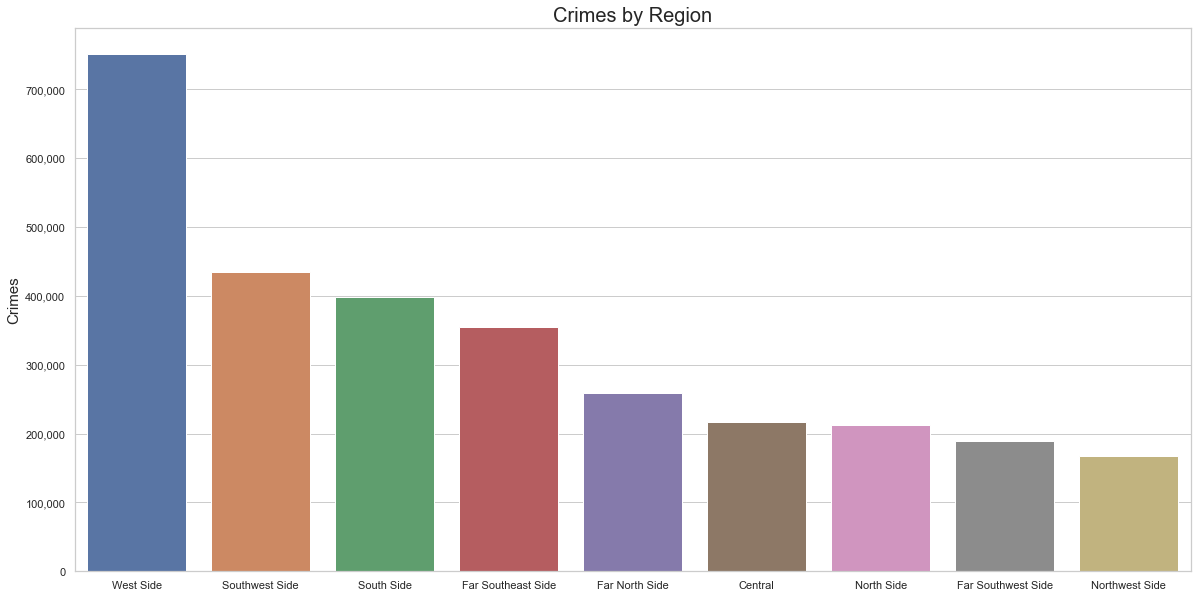

In [102]:
#plotting the crimes by region
plot_crime(region_counts, x_col="Region", y_col="Crimes", title="Crimes by Region")

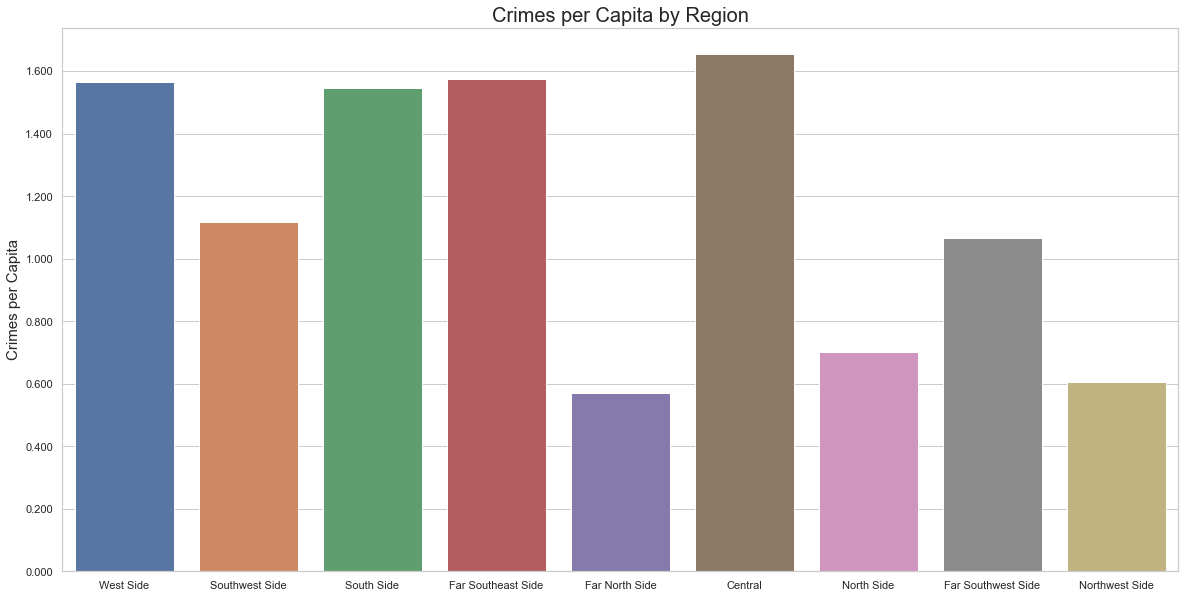

In [103]:
#plotting the crimes by region
plot_crime(region_counts, x_col="Region", y_col="Crimes per Capita", 
           title="Crimes per Capita by Region", y_format='{x:,.3f}')

In [77]:
#grouping the homicides by region
region_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Region']).count().iloc[:,0].sort_values(ascending=False).reset_index()
region_hom_counts.columns = ["Region", "Homicides"]

#normalizing counts with 2010 Population
region_hom_counts = region_hom_counts.merge(region_pop, how='inner', on='Region') 
region_hom_counts['Homicides per Capita'] = region_hom_counts['Homicides'] / region_hom_counts['2010 Population']
region_hom_counts.drop(labels=['2010 Population'], axis=1, inplace=True)
region_hom_counts.head()

,Region,Homicides,Homicides per Capita
0,West Side,3320,0.006907
1,Southwest Side,2248,0.005771
2,Far Southeast Side,1680,0.007474
3,South Side,1658,0.006428
4,Far Southwest Side,795,0.004467


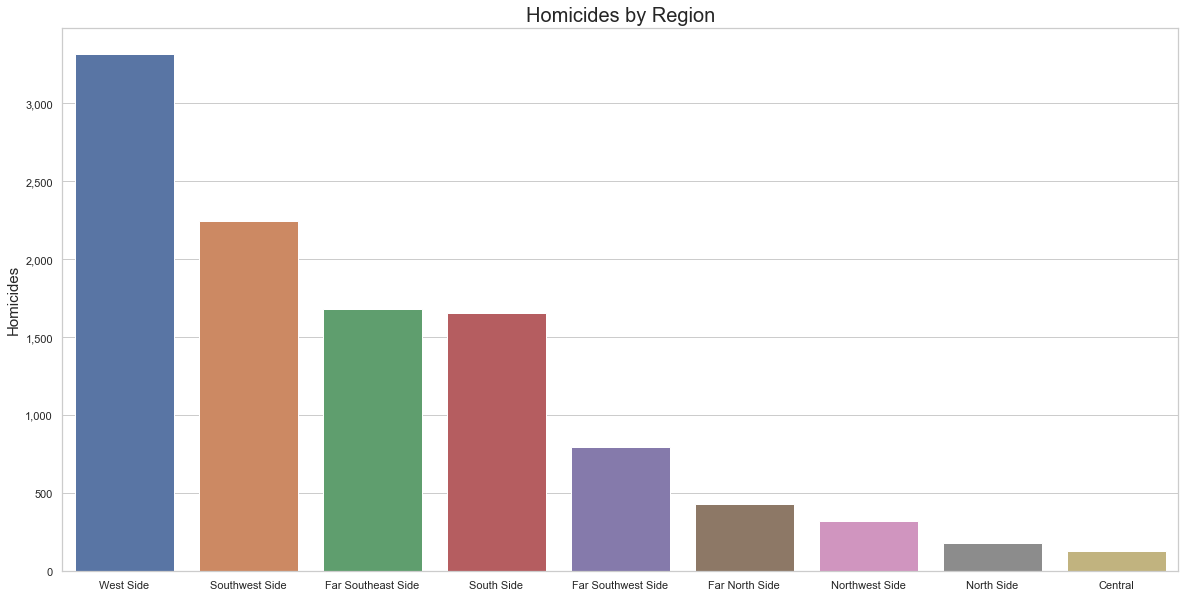

In [104]:
#plotting homicides by region
plot_crime(region_hom_counts, x_col="Region", y_col="Homicides", title="Homicides by Region")

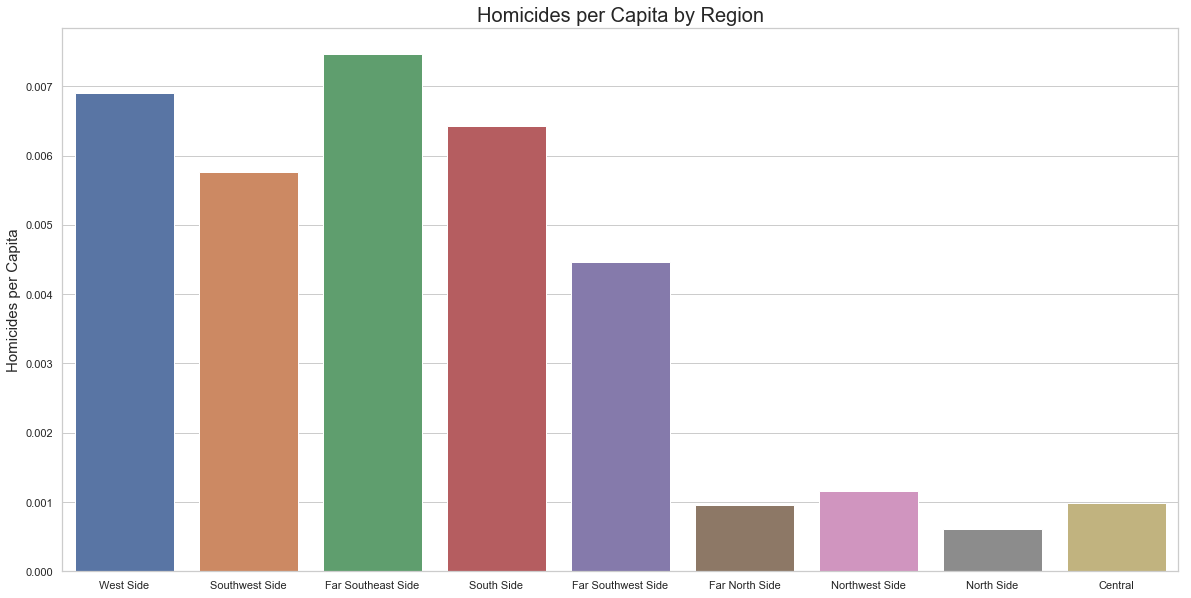

In [105]:
#plotting homicides by region
plot_crime(region_hom_counts, x_col="Region", y_col="Homicides per Capita", 
           title="Homicides per Capita by Region", y_format='{x:,.3f}')

<a id="comm_areas">

## All Crimes and Homicides by Community Area
The plots below support the belief that raw counts of crimes are deceiving. Looking at Fuller Park, it has the 9th lowest amount of crimes but the highest crimes per capita.

In [116]:
#grouping by community area
comm_area_counts = crimes.groupby(['Community Area']).count().iloc[:,0].sort_values(ascending=False).reset_index()
comm_area_counts.columns = ["Community Area", "Crimes"]

#normalizing counts with 2010 Population
comm_area_counts = comm_area_counts.merge(comm_area_pop, how='inner', on='Community Area') 
comm_area_counts['Crimes per Capita'] = comm_area_counts['Crimes'] / comm_area_counts['2010 Population']
comm_area_counts.drop(labels=['2010 Population'], axis=1, inplace=True)
comm_area_counts.head()

,Community Area,Crimes,Region,Crimes per Capita
0,Austin,188085,West Side,1.909221
1,Near North Side,111197,Central,1.381604
2,South Shore,100071,South Side,2.010790
3,North Lawndale,94883,West Side,2.642097
4,Humboldt Park,94681,West Side,1.681036


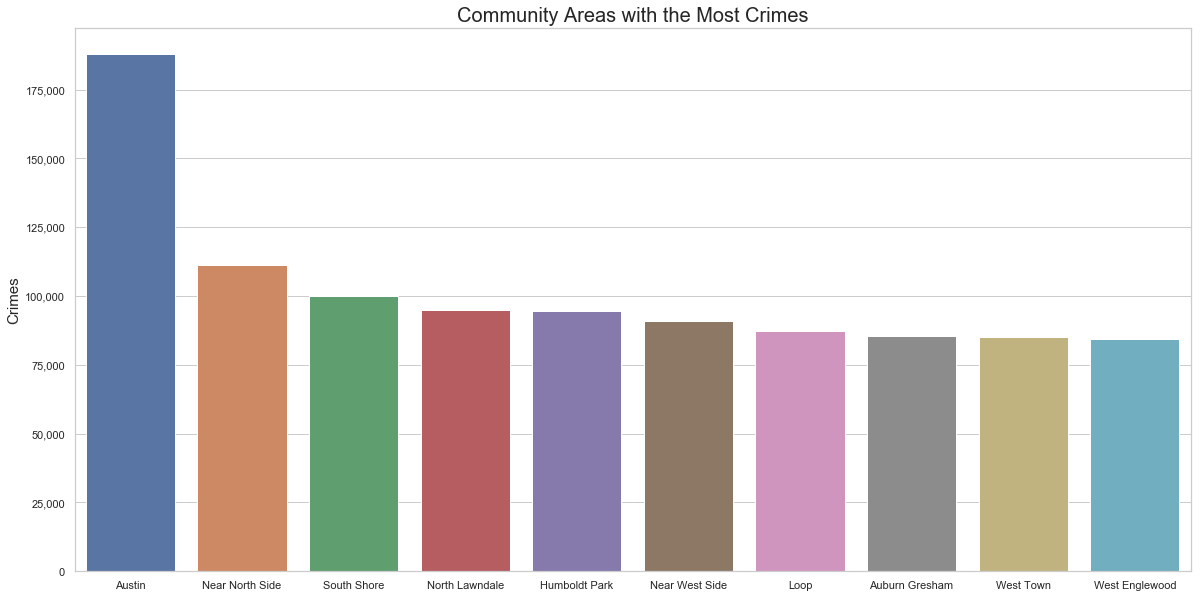

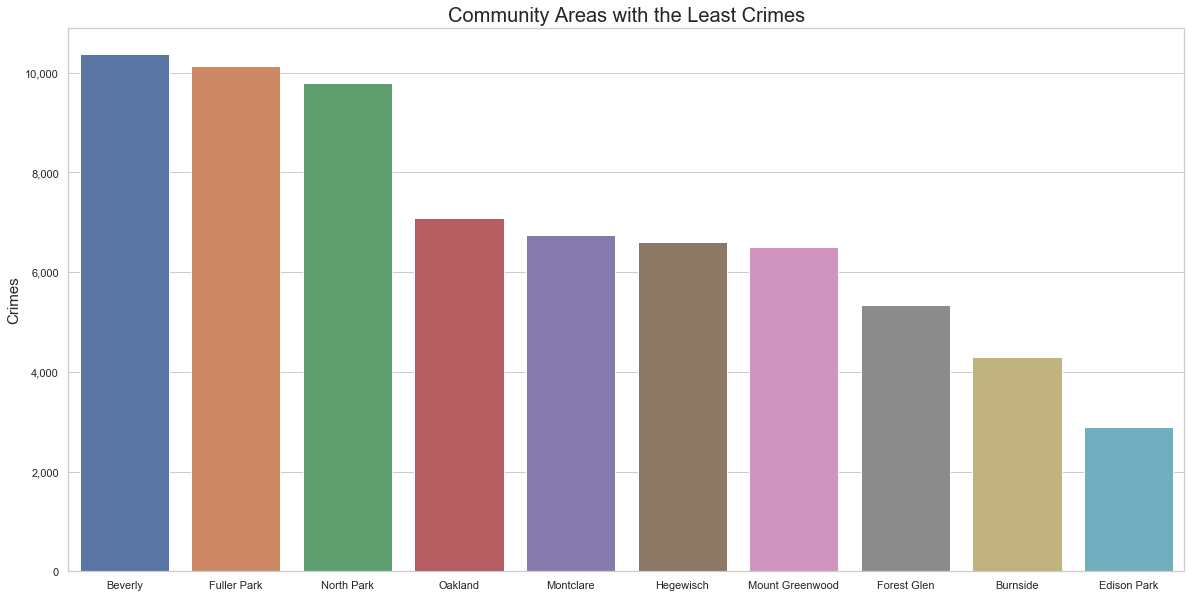

In [117]:
#plotting the Community Areas with the 10 highest counts
plot_crime(comm_area_counts[:10], x_col="Community Area", y_col="Crimes", title="Community Areas with the Most Crimes")

print()

#plotting the Community Areas with the 10 lowest counts
plot_crime(comm_area_counts[-10:], x_col="Community Area", y_col="Crimes", title="Community Areas with the Least Crimes")

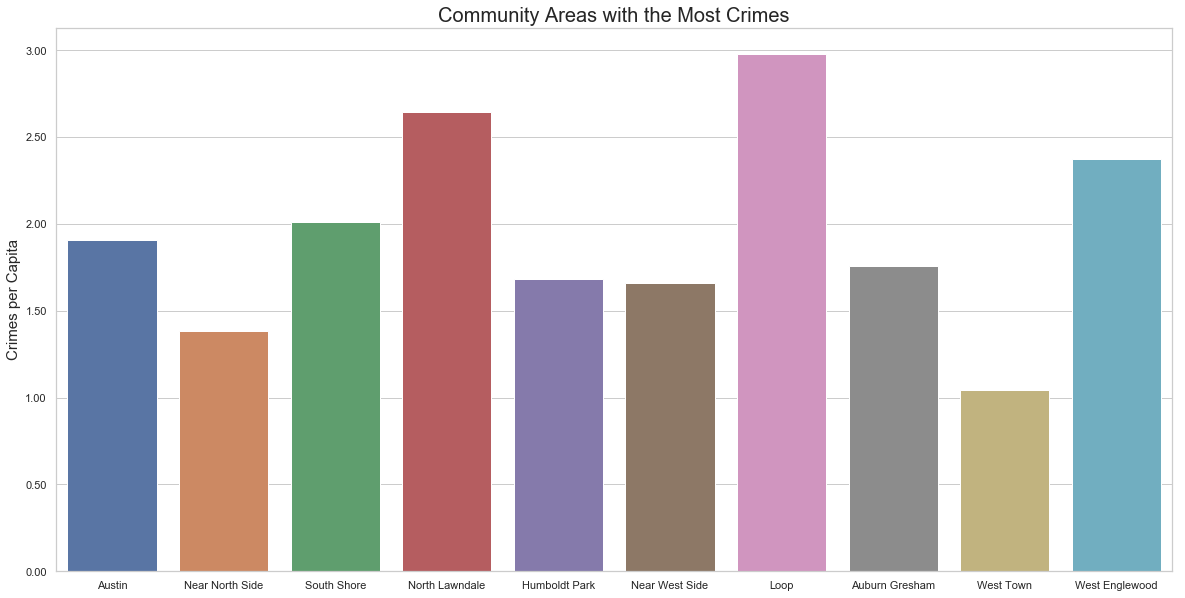

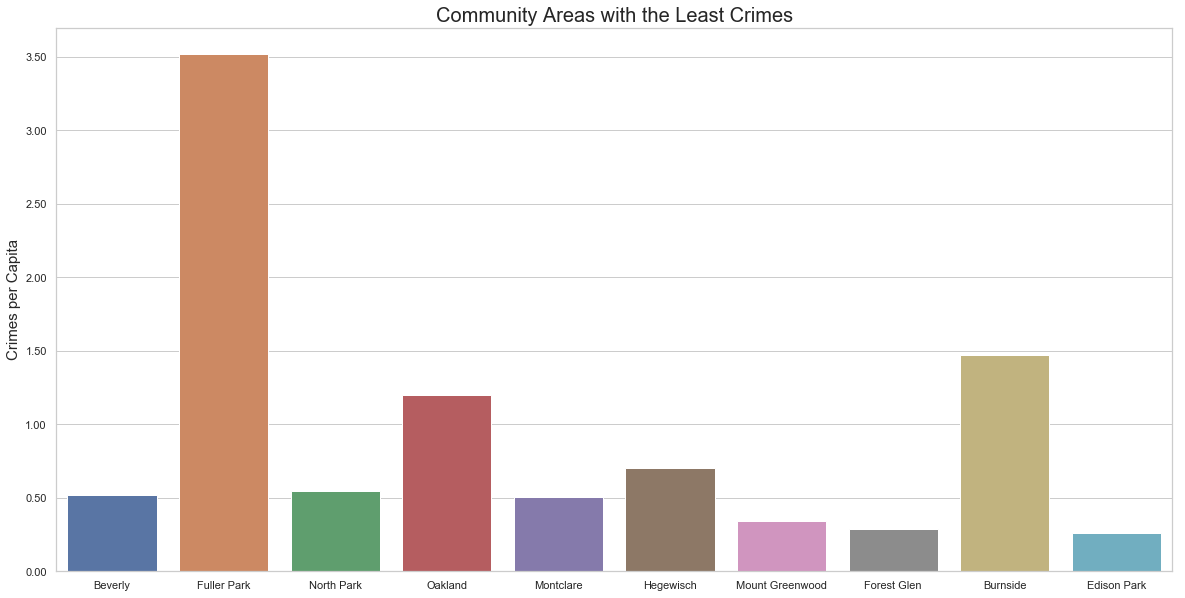

In [108]:
#plotting the Community Areas with the 10 highest counts
plot_crime(comm_area_counts[:10], x_col="Community Area", y_col="Crimes per Capita", 
           title="Community Areas with the Most Crimes", y_format='{x:,.2f}')

print()

#plotting the Community Areas with the 10 lowest counts
plot_crime(comm_area_counts[-10:], x_col="Community Area", y_col="Crimes per Capita", 
           title="Community Areas with the Least Crimes", y_format='{x:,.2f}')

In [112]:
comm_area_counts.iloc[comm_area_counts['Crimes per Capita'].idxmax(),:]

Community Area       Fuller Park
Counts                     10128
Region                South Side
Crimes per Capita        3.52156
Name: 68, dtype: object

In [113]:
#grouping the homicides by community area
comm_area_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Community Area']).count().iloc[:,0].sort_values(ascending=False).reset_index()
comm_area_hom_counts.columns = ["Community Area", "Homicides"]

#normalizing counts with 2010 Population
comm_area_hom_counts = comm_area_hom_counts.merge(comm_area_pop, how='inner', on='Community Area') 
comm_area_hom_counts['Homicides per Capita'] = comm_area_hom_counts['Homicides'] / comm_area_hom_counts['2010 Population']
comm_area_hom_counts.drop(labels=['2010 Population'], axis=1, inplace=True)
comm_area_hom_counts.head()

,Community Area,Homicides,Region,Homicides per Capita
0,Austin,984,West Side,0.009988
1,Englewood,516,Southwest Side,0.016833
2,West Englewood,498,Southwest Side,0.014026
3,Humboldt Park,476,West Side,0.008451
4,North Lawndale,474,West Side,0.013199


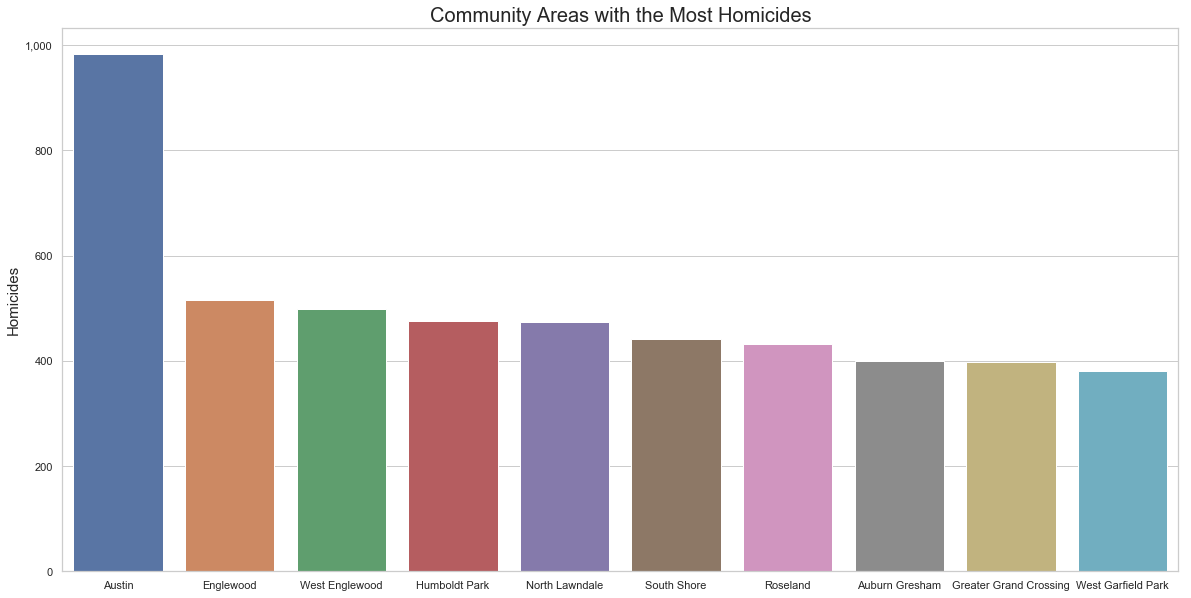

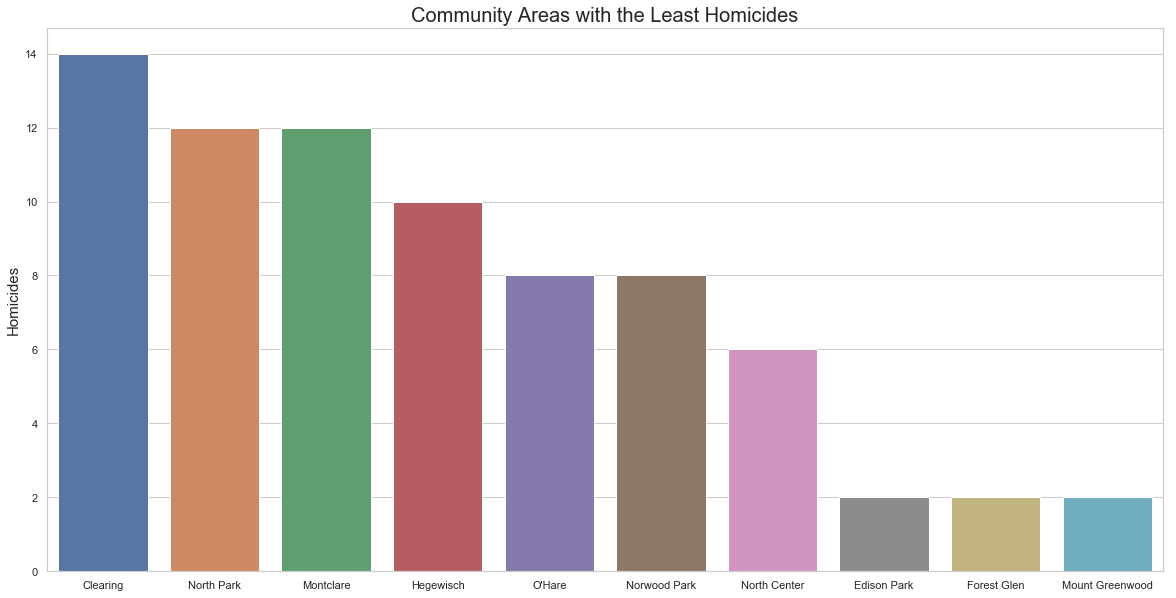

In [115]:
#plotting the community areas with the most homicides
plot_crime(comm_area_hom_counts[:10], x_col="Community Area", y_col="Homicides", 
           title="Community Areas with the Most Homicides")

print()

#plotting the community areas with the least homicides
plot_crime(comm_area_hom_counts[-10:], x_col="Community Area", y_col="Homicides", 
           title="Community Areas with the Least Homicides")

<a id="dates">

## Crimes and Homicides by Date Columns
<a id="date">

### Date
In the first line graph below, there is a cyclical trend showing that more crimes occur in the Spring and Summer with the least occurring in the Winter. There also appears to be a general trend downwards for all the regions. 
  
When plotting the crimes per capita, it is also apparent here that the raw count of crimes can be deceiving.

In [124]:
#grouping by Year, Month, and Region
date_region_counts = crimes.groupby(['Year','Month','Region']).count().iloc[:,0].reset_index()
date_region_counts.columns = ['Year','Month','Region','Crimes']
date_region_counts.sort_values(by=['Year', 'Month'], ascending=True, inplace=True)

#adding crimes per capita
date_region_counts = date_region_counts.merge(region_pop, how='inner', on='Region') 
date_region_counts['Crimes per Capita'] = date_region_counts['Crimes'] / date_region_counts['2010 Population']
date_region_counts.drop(labels=['2010 Population'], axis=1, inplace=True)

#creating Year-Month column and dropping Year and Month
date_region_counts['Year-Month'] = date_region_counts['Year'].astype(str) + '-' + date_region_counts['Month'].astype(str)

In [125]:
date_region_counts.head()

,Year,Month,Region,Crimes,Crimes per Capita,Year-Month
0,2010,1,Central,1721,0.013122,2010-1
1,2010,2,Central,1525,0.011627,2010-2
2,2010,3,Central,1755,0.013381,2010-3
3,2010,4,Central,1727,0.013167,2010-4
4,2010,5,Central,1781,0.013579,2010-5


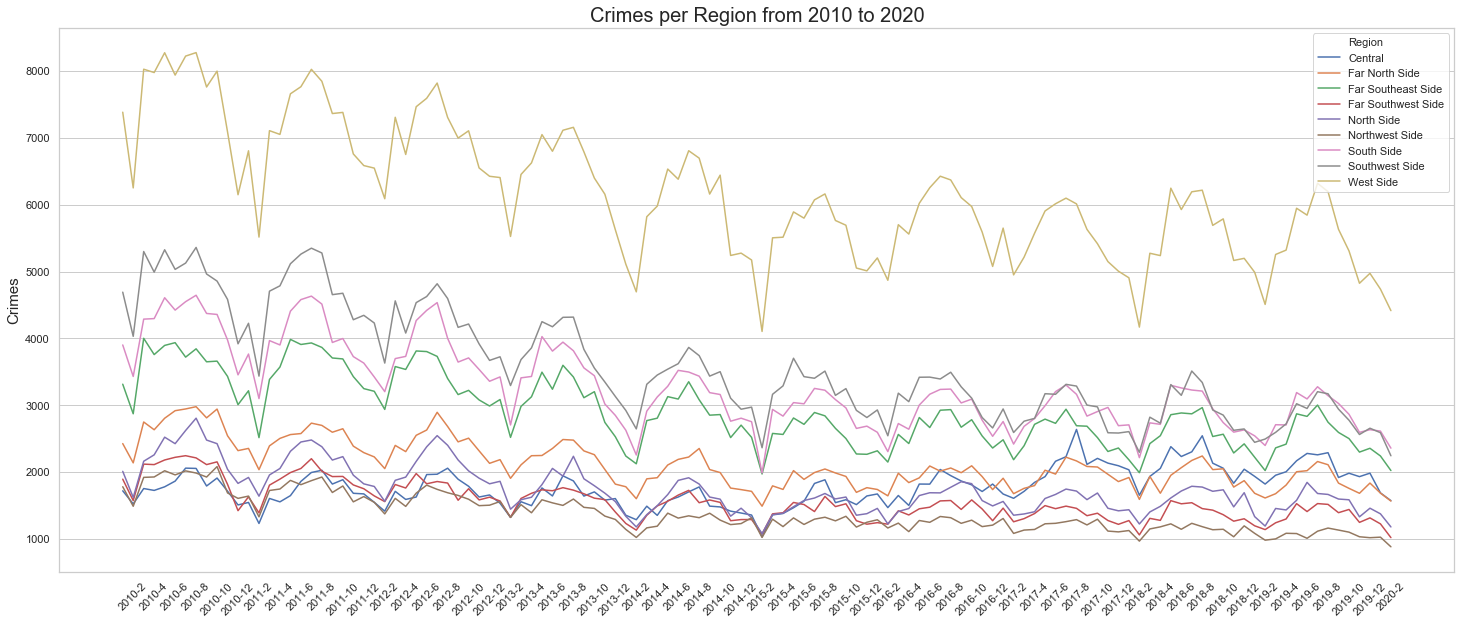

In [126]:
fig,ax = plt.subplots(figsize=(25,10))
ax = sns.lineplot(data=date_region_counts, x="Year-Month", y="Crimes", hue="Region", sort=False)

#only showing every other Month-Year label
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.title("Crimes per Region from 2010 to 2020", fontsize=20)
plt.xticks(rotation=45)
ax.xaxis.grid(False)
ax.yaxis.grid(True)
plt.xlabel(None)
plt.ylabel("Crimes", fontsize=15)
plt.show()

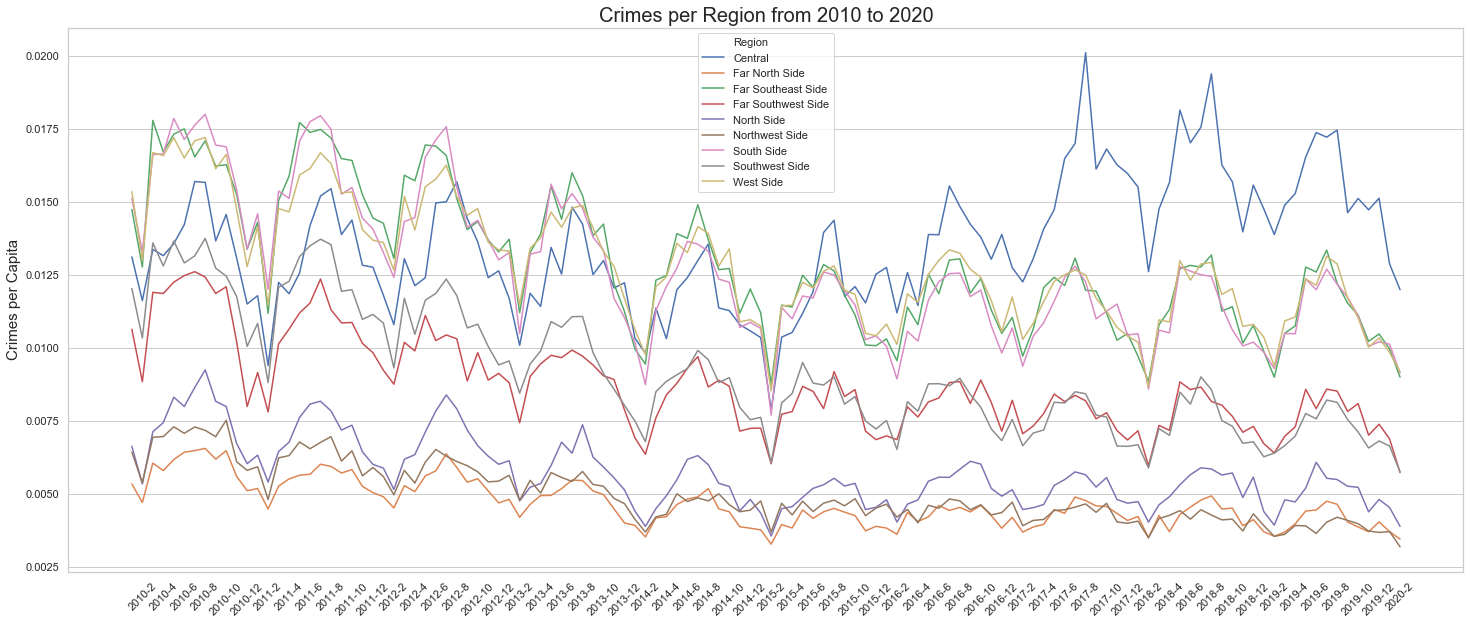

In [128]:
fig,ax = plt.subplots(figsize=(25,10))
ax = sns.lineplot(data=date_region_counts, x="Year-Month", y="Crimes per Capita", hue="Region", sort=False)

#only showing every other Month-Year label
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.title("Crimes per Region from 2010 to 2020", fontsize=20)
plt.xticks(rotation=45)
ax.xaxis.grid(False)
ax.yaxis.grid(True)
plt.xlabel(None)
plt.ylabel("Crimes per Capita", fontsize=15)
plt.show()

<a id="time">

### Time of Day
Confirming what I believed, most homicides occur at night. However, the most crimes occur during the afternoon, which surprised me. 

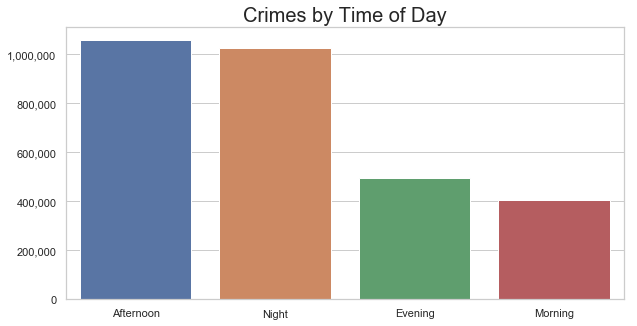

In [140]:
#grouping the crimes by time of day
time_counts = crimes.groupby(['Time of Day']).count().iloc[:,0].sort_values(ascending=False).reset_index()
time_counts.columns = ["Time of Day", "Counts"]

#plotting crimes by time of day
plot_crime(time_counts, x_col="Time of Day", y_col="Counts", title="Crimes by Time of Day", fig_size=(10,5))

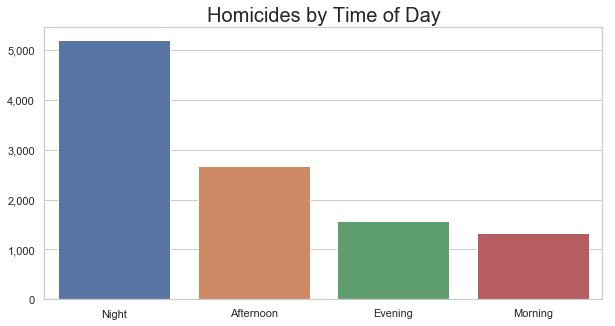

In [142]:
#grouping the homicides by time of day
time_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Time of Day']).count().iloc[:,0].sort_values(ascending=False).reset_index()
time_hom_counts.columns = ["Time of Day", "Counts"]

#plotting homicides by time of day
plot_crime(time_hom_counts, x_col="Time of Day", y_col="Counts", title="Homicides by Time of Day", fig_size=(10,5))

<a id="season">

### Season
As expected, there are more crimes and homicides during the summer than all other seasons. My assumption, although I am unable to confirm this, is this has to do with the warmer weather leading to more people being outside, and therefore, more vunerable to crime.

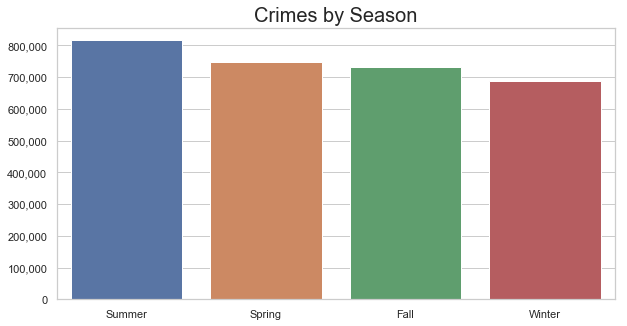

In [138]:
#grouping the crimes by season
season_counts = crimes.groupby(['Season']).count().iloc[:,0].sort_values(ascending=False).reset_index()
season_counts.columns = ["Season", "Counts"]

#plotting crimes by season
plot_crime(season_counts, x_col="Season", y_col="Counts", title="Crimes by Time of Day", fig_size=(10,5))

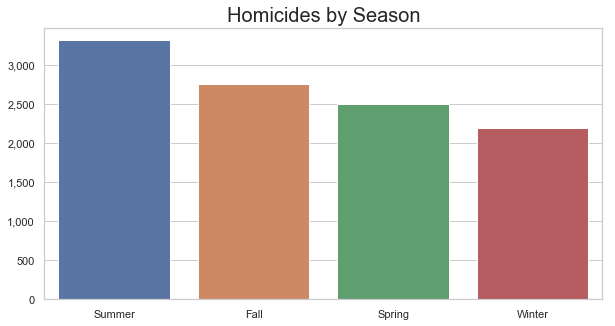

In [137]:
#grouping the homicides by season
season_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Season']).count().iloc[:,0].sort_values(ascending=False).reset_index()
season_hom_counts.columns = ["Season", "Counts"]

#plotting homicides by season
plot_crime(season_hom_counts, x_col="Season", y_col="Counts", title="Homicides by Season", fig_size=(10,5))